In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import Tube, InterpXY, BorderSimple
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
# %config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

import json
from functional import seq
import ipdb

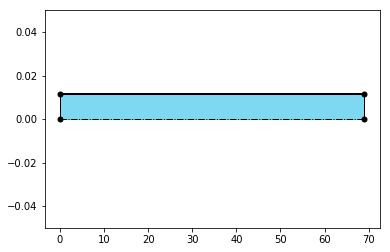

GasLayer(n_cells=300); 
        {'p_max':100000.0, 'tau_min': 0.0006624639388052124, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.22999999999998977, 
        'x_1': 0.0, 'x_2': 69.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [10]:
d = 0.023
m = 0.035
l_max = 3000*d
p0 = 1e5
x_0 = l_max

gas_layer_dict_sample = {
    'type': 'gas',
    'name': 'air',
    'gamma': 1.4,
    'kappa': 0, #0.0010838,
    'R': 287,
    'T_0': 300, # K
    'W_0': 0.0003,  # м^3 объем газа
    'p_0': p0, # начальное давление газа
    'u_0': 0,     #начальная скорость
    'x_2': x_0
}

tube_dict = {
    'tube_points': [[0, d], [l_max, d]]
}

calc_settings_sample = {
    'cell_dx': 0.0025,
    'n_cells': 300,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':1 },
    'GridStrecher_kwargs': {}
}   
tube=Tube.get_standart(tube_dict)
gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()
lrs = [gl]
gl

In [11]:

for i in tqdm_notebook(range(20000)):
    if gl.time > 70e-3:
        break
    tau = gl.get_tau_min()*0.5
    v = gl.Vs_borders[0] + 20000*tau
    gl = gl.step_simple(tau, v, 0)
    lrs.append(gl)

In [15]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=10, value=0))
def plotMe(ind):
    param_name = 'ps'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,1)
    plt.title(f't={lr.time*1000} ms; i={ind}, v={lr.Vs_borders[0]}, p={lr.ps[0]/1e5}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=925, step=10), Output()), _dom_classes=('widge…

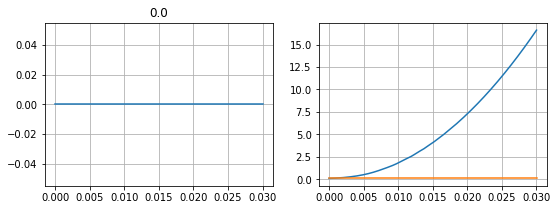

In [7]:
mpl.rcParams['figure.figsize'] = (9,3) 
vt = seq(lrs).map(lambda lr: lr.Vs_borders[-1]).to_list()
t = seq(lrs).map(lambda lr: lr.time).to_list()
p_1 = seq(lrs).map(lambda lr: lr.ps[0]/1e6).to_list() 
p_2 = seq(lrs).map(lambda lr: lr.ps[-1]/1e6).to_list() 
plt.subplot(121)
plt.plot(t, vt)
plt.title(vt[-1])
plt.grid()
plt.subplot(122)
plt.plot(t, p_1)
plt.plot(t, p_2)
plt.grid()
plt.show()

In [8]:
def forw(x_0, p_0, n_cells=300):
    d = 0.023
    m = 0.035
    l_max = 35*d
    p0 = p_0

    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'N_2',
        'gamma': 1.4,
        'kappa': 0, #0.0010838,
        'R': 287,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': x_0
    }

    tube_dict = {
        'tube_points': [[0, d], [l_max, d]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':1 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    for i in range(30000):
        if gl.xs_borders[-1] > l_max:
            break
        tau = gl.get_tau_min()*0.5
        v = gl.Vs_borders[-1] + gl.ps[-1]*pi*d**2/4/m*tau
        gl = gl.step_simple(tau, 0, v)
    else:
        print(f'Ошибочка в {x_0} {p_0}')
    return v

In [9]:
forw(0.3, 5e6)

164.62482950842383

In [313]:
def forw2(gv, n_cells=1000, steps=20000, T_0_cels=20):
    d = 0.023
    m = 0.035
    l_max = 3000*d
    p0 = 1e5

    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'air',
        'gamma': 1.4,
        'kappa': 0, #0.0010838,
        'R': 287,
        'T_0': T_0_cels + 273.15, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': l_max
    }

    tube_dict = {
        'tube_points': [[0, d], [l_max, d]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': {'flux_type':1 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    vs = [0]
    ps = [p0]
    for i in range(steps):
        if gl.time > 30e-3 or gl.Vs_borders[0]>2200:
            break
        tau = gl.get_tau_min()*0.5
        v = gl.Vs_borders[0] + gv*tau
        gl = gl.step_simple(tau, v, 0)
        vs.append(v)
        ps.append(gl.ps[0])
    else:
        print(f'Ошибочка в {gv}')
    return np.array(vs), np.array(ps)

In [314]:
d20 = {g: forw2(g, T_0_cels=+20) for g in tqdm_notebook([300,1000,3000, 5000, 8000, 10000,20000,50000,100000])}

<IPython.core.display.Javascript object>


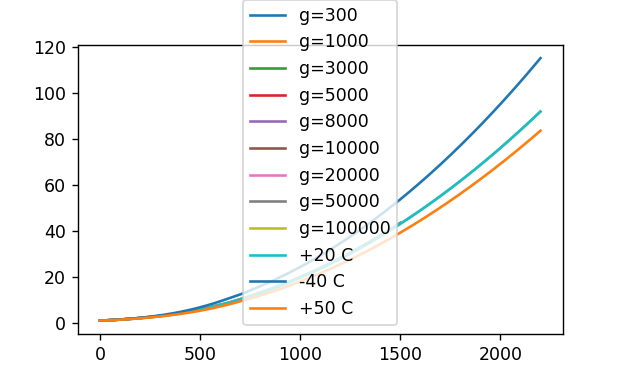

In [315]:
for g, (vs,ps) in d20.items():
    plt.plot(vs,ps*1e-5, label=f'g={g}')
plt.legend()
plt.grid()
plt.show()

In [316]:
d20 = {g: forw2(g, T_0_cels=+20) for g in tqdm_notebook([100000])}
d_40 = {g: forw2(g, T_0_cels=-40) for g in tqdm_notebook([100000])}
d50 = {g: forw2(g, T_0_cels=+50) for g in tqdm_notebook([100000])}

<IPython.core.display.Javascript object>


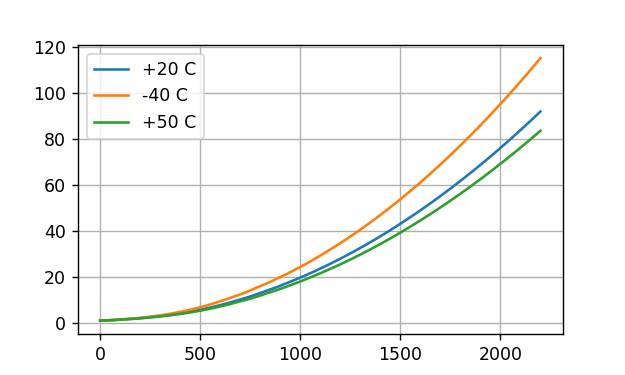

In [318]:
for g, (vs,ps) in d20.items():
    plt.plot(vs,ps*1e-5, label=f'+20 C')
for g, (vs,ps) in d_40.items():
    plt.plot(vs,ps*1e-5, label=f'-40 C')
for g, (vs,ps) in d50.items():
    plt.plot(vs,ps*1e-5, label=f'+50 C')
plt.legend()
plt.grid()
plt.show()

In [319]:
from math import *
%matplotlib notebook

def foo_p(u, p0=1e5,T_0=20):
    T_0 += 273.15
    ro0 = p0/287/T_0
    k=1.4
#     P**2 - P (2 p0 + ro0 (k+1)0.5 u**2) + (p0**2 - (k-1)0.5 p0 u**2) = 0
    a = 1
    b = -(2*p0 + ro0*(k+1)*0.5*u**2)
    c = (p0**2 - (k-1)*0.5*p0*u**2)
    D = b**2 - 4*a*c
    return (-b+sqrt(D))/2/a 
    
     

<IPython.core.display.Javascript object>


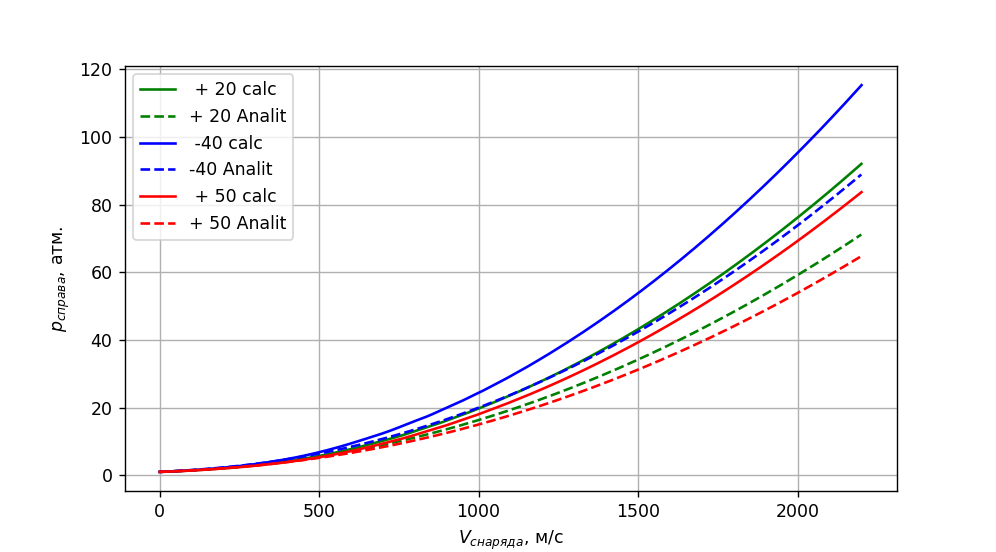

In [320]:
for g, (vs,ps) in d20.items():
    plt.plot(vs,ps*1e-5, color='green', label=f' + 20 calc')
    
us = np.linspace(0,2200, 1000)
ps = [foo_p(u, T_0=20)*1e-5 for u in us]
plt.plot(us, ps, label='+ 20 Analit', color='green', ls='--')

for g, (vs,ps) in d_40.items():
    plt.plot(vs,ps*1e-5, color='blue', label=f' -40 calc')
    
us = np.linspace(0,2200, 1000)
ps = [foo_p(u, T_0=-40)*1e-5 for u in us]
plt.plot(us, ps, label='-40 Analit', color='blue', ls='--')

for g, (vs,ps) in d50.items():
    plt.plot(vs,ps*1e-5, color='red', label=f' + 50 calc')
    
us = np.linspace(0,2200, 1000)
ps = [foo_p(u, T_0=50)*1e-5 for u in us]
plt.plot(us, ps, label='+ 50 Analit', color='red', ls='--')



plt.legend()
plt.ylabel('$p_{справа}$, атм.')
plt.xlabel('$V_{снаряда}$, м/с')
plt.grid()
plt.show()

In [321]:
d_all = {T: forw2(100000, T_0_cels=T) for T in tqdm_notebook(np.linspace(-40,50,91))}

<IPython.core.display.Javascript object>


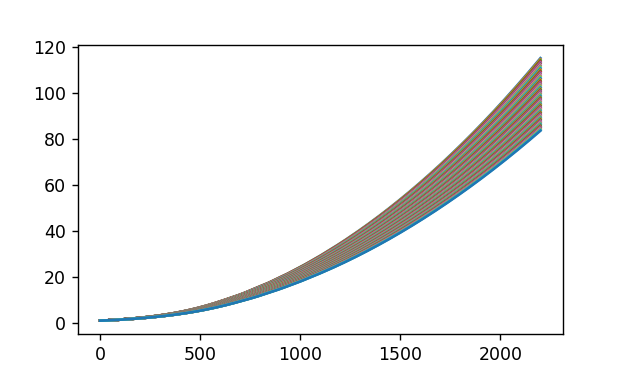

In [324]:
for g, (vs,ps) in d_all.items():
    plt.plot(vs,ps*1e-5)
plt.show()

In [323]:
from sklearn.linear_model import LinearRegression

In [355]:
xs = []
ys = []
ws = []
def v_to(v):
    return [v, v**2, v**3]

vs, ps = d_all[20.]
for v, p in zip(vs, ps):
    xs.append(v_to(v))
    ws.append(1/(0.1+0.001*v))
    ys.append(p/1e5)  
    
from scipy.special import softmax

ws = softmax(ws)
reg = LinearRegression().fit(xs, ys, ws)
reg.score(xs, ys), reg.coef_, reg.intercept_

(0.999985067196709,
 array([1.19195961e-03, 1.70276499e-05, 5.79370144e-10]),
 1.014458801744054)

<IPython.core.display.Javascript object>


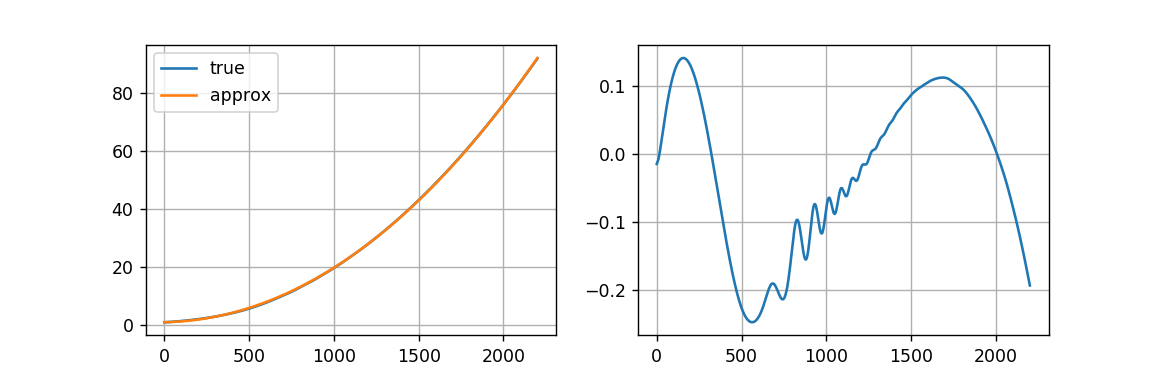

In [363]:
vs,ps = d_all[20.]
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(vs, ps*1e-5, label='true')
ax1.plot(vs, reg.predict([v_to(v) for v in vs]), label='approx')
ax1.legend()
ax1.grid()

ax2.plot(vs, ((ps*1e-5) - reg.predict([v_to(v) for v in vs])))
ax2.grid()
plt.show()

In [359]:
1/5.79370144e-10**(1/3)

1199.539709804844

<IPython.core.display.Javascript object>


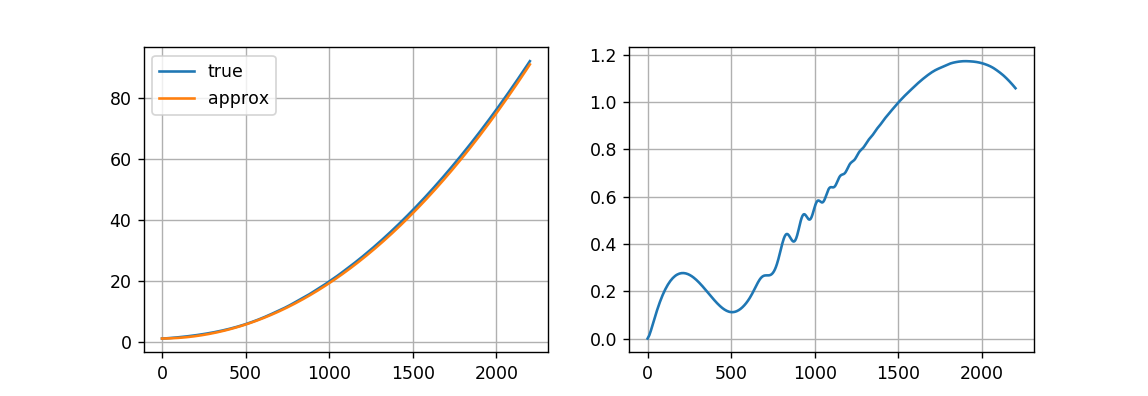

In [362]:
def p_sopr(v):
    return 1 + v/1920 + (v/242)**2 + (v/1199)**3

vs,ps = d_all[20.]
ps_pred = p_sopr(vs)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(vs, ps*1e-5, label='true')
ax1.plot(vs, ps_pred, label='approx')
ax1.legend()
ax1.grid()

ax2.plot(vs, ((ps*1e-5) - ps_pred))
ax2.grid()
plt.show()

In [287]:
xs = []
ys = []
ws = []
def vT_to(v, T):
    t = T+50
    return [v, t,v*t, v**2, (t*v/100000)**3]

for T, (vs,ps) in d_all.items():
    for v, p in zip(vs, ps):
#         if v > 2200:
#             break
        xs.append(vT_to(v, T))
        ws.append(1/(1+v))
        ys.append(p/1e5)
xs = np.asarray(xs)
ys = np.asarray(ys)
ws = np.asarray(ws)

In [288]:
reg = LinearRegression().fit(xs, ys,ws)
reg.score(xs, ys), reg.coef_, reg.intercept_

(0.9985715702190603,
 array([ 7.47001470e-03,  2.06690315e-02, -1.52363915e-04,  2.06987177e-05,
        -4.39602183e-01]),
 -0.0461910143913542)

<IPython.core.display.Javascript object>


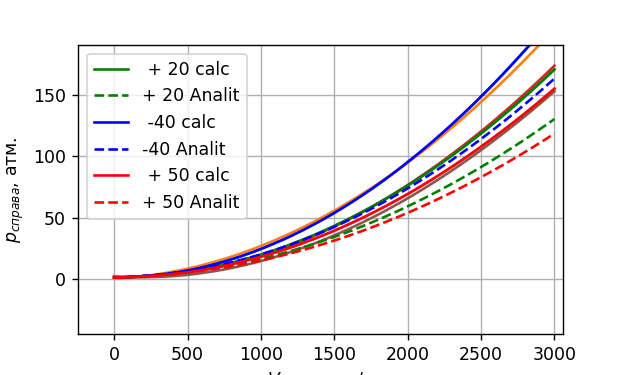

In [289]:
for T in [-40.,20.,50.]:
    vs,ps = d_all[T]
    plt.plot(vs,(ps*1e-5))
    plt.plot(vs, reg.predict([vT_to(v, T) for v in vs]))
plt.show()

In [249]:
1/(1.35280647e-03)**(1/2)

27.18830693725438

In [192]:
xs = []
ys = []
for T, (vs,ps) in d_all.items():
    for v, p in zip(vs, ps):
        if v > 2200:
            break
        xs.append([(v/200)**2, (v/2000)**3])
        ys.append(p/1e5)
    break
xs = np.asarray(xs)
ys = np.asarray(ys)
reg = LinearRegression().fit(xs, ys)
reg.score(xs, ys), reg.coef_, reg.intercept_

(0.999998468038097, array([0.92231735, 1.93265639]), 1.1038344005864786)

In [188]:
1/(2.36517667e-05)**(1/2)

205.62135027853563

In [180]:
1/sqrt(2.37449969e-05)

205.21728676828687

In [116]:
def powy(a, b): 
    xs = []
    ys = []
    for T, (vs,ps) in d_all.items():
        for v, p in zip(vs, ps):
            xs.append([(T+273.15+v)**b, (v/340)**(a)])
            ys.append(p/1e5)
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    reg = LinearRegression().fit(xs, ys)
    return reg.score(xs, ys)
    
ass = np.linspace(1.8,2.0,100)
bss = np.linspace(2,2,1)

scores = []
for a in tqdm_notebook(ass):
    ys = [powy(a, b) for b in bss]
    scores.append(ys)


<IPython.core.display.Javascript object>


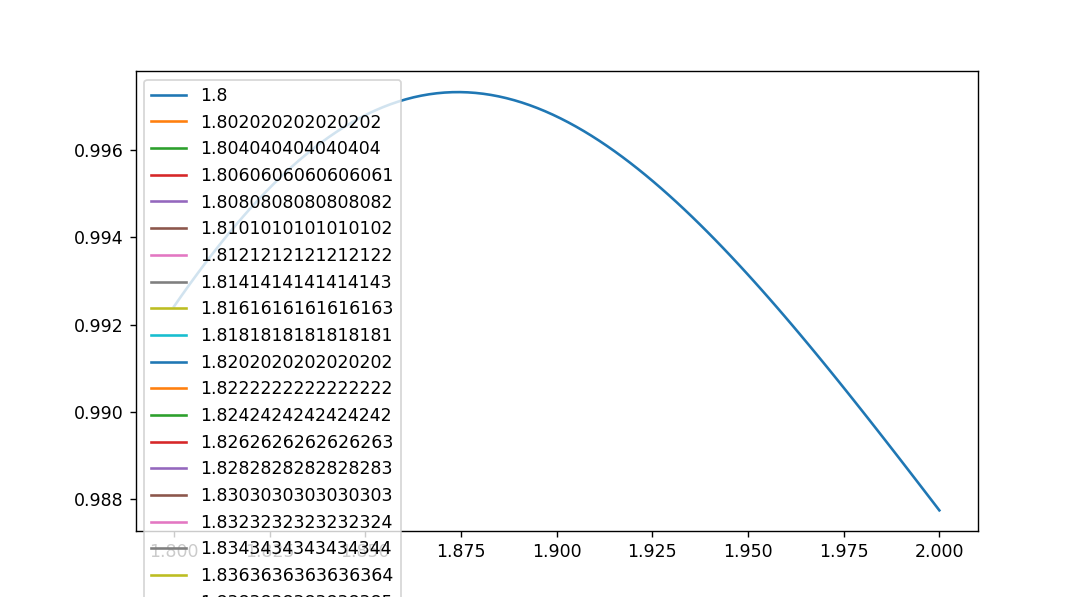

In [117]:
for a, ys in zip(ass, scores):
    plt.plot(bss, ys, label=f'{a}')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


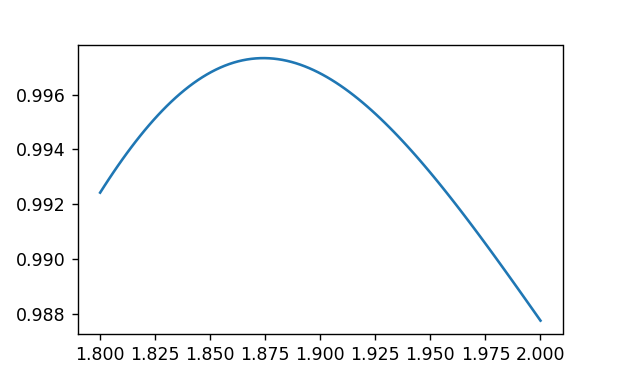

In [119]:
plt.plot(ass, [ys[0] for ys in scores])